# Analyze performance of LSTM (Model 2) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 2 using data from Shasta reservoir.
Recall that LSTM Model 2 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. Model 2 is also
autoregressive, i.e. previous outputs are fed in as inputs in the next timestep. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.
4. Analyze relationship between cell states and observed storage

We analyze the following variants of Model 2:
1. Model 2a: standardized data, trained on MSE loss
2. Model 2b: normalized data, trained on RMSLE loss

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *
from torch.utils.data import DataLoader, TensorDataset

# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized data

In [4]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_std, dataset_val_std = (TensorDataset(X_train_std, y_train_std), TensorDataset(X_val_std, y_val_std))
# shuffle = False to preserve time order
dataloader_train_std, dataloader_val_std = (DataLoader(dataset_train_std, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_std, batch_size=1, shuffle=False))

### Normalized data

In [5]:
# Run data processing pipeline
pipeline_nm = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1, transform_type='normalize', fill_na_method='mean')
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_nm, ts_val_nm, ts_test_nm = pipeline_nm.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_nm, X_val_nm, X_test_nm = ts_train_nm[:, :, [0, 3]], ts_val_nm[:, :, [0, 3]], ts_test_nm[:, :, [0, 3]]
# select outflow as target feature
y_train_nm, y_val_nm, y_test_nm = ts_train_nm[:, :, [1]], ts_val_nm[:, :, [1]], ts_test_nm[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_nm, dataset_val_nm = (TensorDataset(X_train_nm, y_train_nm), TensorDataset(X_val_nm, y_val_nm))
# shuffle = False to preserve time order
dataloader_train_nm, dataloader_val_nm = (DataLoader(dataset_train_nm, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_nm, batch_size=1, shuffle=False))

In [6]:
# check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

## Analyze Model 2a

### Analyze Optimal Hyperparameters

We conducted a small grid search around the optimal parameters of Model 1 (since the two models are similar). The search space is as follows: \
Number LSTM layers; 1, 2\
Hidden size (LSTM): 25, 30, 35\
Hidden size (FF): 10, 15, 20\
Dropout probability: 0.3

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [7]:
# load in results from grid search
grid_df_2a = pd.read_csv('report/results/hyperparameter_tuning/model2a_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_2a['param_id'] = np.repeat(np.arange(int(len(grid_df_2a) / num_random_seeds)), num_random_seeds)
grid_df_mean_2a = grid_df_2a.groupby('param_id').mean()
grid_df_mean_2a.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_2a.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_2a.to_csv('report/results/hyperparameter_tuning/model2a_avg_tuning.csv')
grid_df_mean_2a[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
14,1.0,35.0,20.0,0.3,58.0,0.382120
7,1.0,30.0,15.0,0.3,56.6,0.382865
1,1.0,25.0,15.0,0.3,72.2,0.382899
8,1.0,30.0,20.0,0.3,55.4,0.403473
2,1.0,25.0,20.0,0.3,66.4,0.405787
13,1.0,35.0,15.0,0.3,62.6,0.411406
17,2.0,35.0,20.0,0.3,56.2,0.418225
6,1.0,30.0,10.0,0.3,59.6,0.419644
3,2.0,25.0,10.0,0.3,49.2,0.423697


### Load model with optimal hyperparaeters

The optimal hyperparameters are:\
Number  of LSTM layers: 1\
LSTM hidden units: 35\
FF hidden units: 15\
dropout: 0.3

In [8]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *

In [9]:
# instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 20
num_layers = 1
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model2a = LSTMModel2(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob, initial_output=0)

In [10]:
count_parameters(model2a)

16421

In [11]:
# load saved model parameters
model2a.load_state_dict(torch.load('src/models/saved_models/model2a.pt'))

<All keys matched successfully>

In [12]:
model2a.eval()

LSTMModel2(
  (lstm_cell1): LSTMCell(3, 35)
  (lstm_cell2): LSTMCell(35, 35)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=35, out_features=20, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=20, out_features=1, bias=True)
)

### Evaluate Model 2a goodness-of-fit

In [13]:
from src.models.predict_model import *
from sklearn.metrics import r2_score

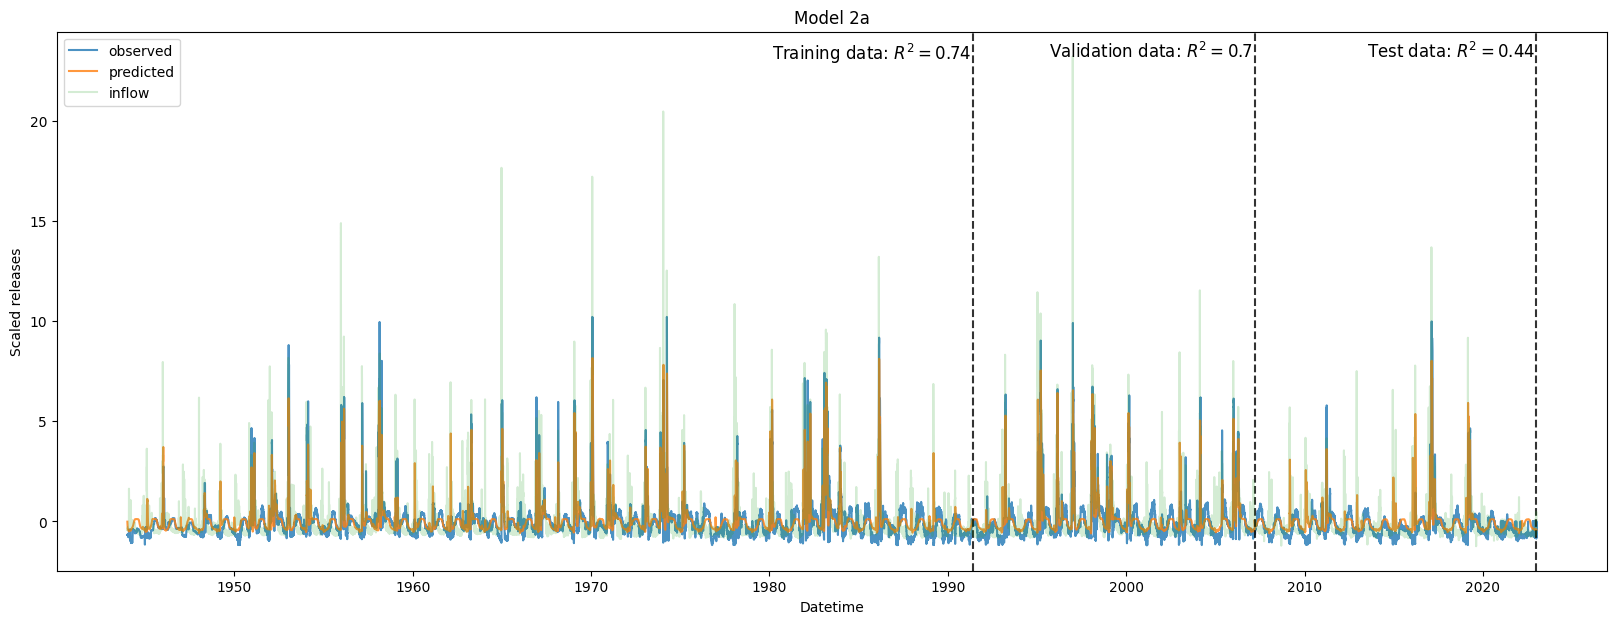

In [15]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_2a, r2_val_2a, r2_test_2a = plot_and_eval(model2a, X_train_std, X_val_std, X_test_std, y_train_std, y_val_std, y_test_std, datetime_index=df.index, ax=ax, text_ypos=24, alpha=0.8)
ax.plot((df.inflow-df.inflow.mean()) / df.inflow.std(), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 2a')
# plt.savefig('report/progress_report_1_23_24/figures/model2a.png',dpi=300)
plt.show()

## Analyze Model 2b

### Analyze Optimal Hyperparameters

We conducted a small grid search around the optimal parameters of Model 1 (since the two models are similar). The search space is as follows: \
Number LSTM layers; 1, 2\
Hidden size (LSTM): 20, 25, 30\
Hidden size (FF): 20, 25, 30\
Dropout probability: 0.3

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [16]:
# load in results from grid search
grid_df_2b = pd.read_csv('report/results/hyperparameter_tuning/model2b_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_2b['param_id'] = np.repeat(np.arange(int(len(grid_df_2b) / num_random_seeds)), num_random_seeds)
grid_df_mean_2b = grid_df_2b.groupby('param_id').mean()
grid_df_mean_2b.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_2b.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_2b.to_csv('report/results/hyperparameter_tuning/model2b_avg_tuning.csv')
grid_df_mean_2b[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
10,2.0,25.0,25.0,0.3,137.8,0.043130
15,2.0,30.0,20.0,0.3,109.6,0.044051
6,1.0,25.0,20.0,0.3,133.4,0.044062
2,1.0,20.0,30.0,0.3,137.4,0.044467
14,1.0,30.0,30.0,0.3,83.4,0.044579
7,1.0,25.0,25.0,0.3,106.0,0.044899
5,2.0,20.0,30.0,0.3,112.8,0.045126
16,2.0,30.0,25.0,0.3,97.2,0.045221
0,1.0,20.0,20.0,0.3,129.4,0.045554


In [18]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.predict_model import *
from sklearn.metrics import r2_score

In [19]:
# load optimal model
# instantiate model
input_size = 2
hidden_size1 = 25
hidden_size2 = 25
num_layers = 2
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model2b = LSTMModel2(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0)

# load saved model parameters
model2b.load_state_dict(torch.load('src/models/saved_models/model2b.pt'))

<All keys matched successfully>

In [20]:
model2b.eval()

LSTMModel2(
  (lstm_cell1): LSTMCell(3, 25)
  (lstm_cell2): LSTMCell(25, 25)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=25, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=25, out_features=1, bias=True)
)

### Evaluate Model 2b goodness-of-fit

In [21]:
from src.models.predict_model import *

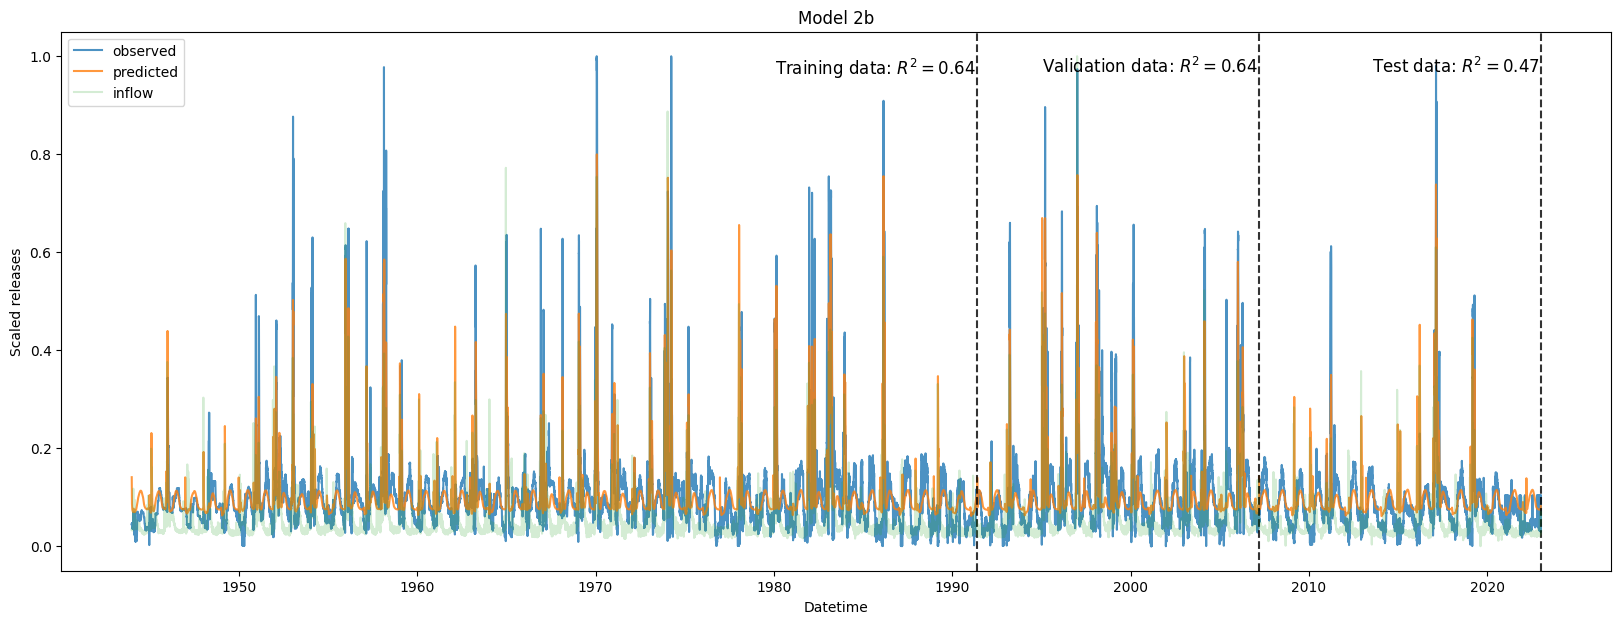

In [22]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_2b, r2_val_2b, r2_test_2b = plot_and_eval(model2b, X_train_nm, X_val_nm, X_test_nm, y_train_nm, y_val_nm, y_test_nm, datetime_index=df.index, ax=ax, text_ypos=1, alpha=0.8)
ax.plot((df.inflow-df.inflow.min()) / (df.inflow.max() - df.inflow.min()), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 2b')
# plt.savefig('report/progress_report_1_23_24/figures/model2b.png',dpi=300)
plt.show()

## Review performance

In [23]:
performance = {'training r2': [r2_train_2a, r2_train_2b],
               'validation r2' : [r2_val_2a, r2_val_2b], 
               'testing r2': [r2_test_2a, r2_test_2b]}
perf_df = pd.DataFrame(performance, index=['Model 2a', 'Model 2b'])
perf_df

,training r2,validation r2,testing r2
Model 2a,0.737818,0.703376,0.435286
Model 2b,0.640674,0.642510,0.468054
